# Tuning Up TWPA:

---

## To Do:

- config from data file
- line plots from heatmap
- 2D peak finder
    - high SNR
    - clustered high
- automated script


## Idea:


1. Method to average the 2D color plots 
    a. Store the averaged plots
2. Method to calculate SNR from Signal
3. For each pump frequency:
    For each point on averaged plots:
        a. calculate SNR
        b. extract regions of stable high SNR
4. Create 3D plot with color = SNR, and <x = pump freq., y = pump power, z  = SNR>
5. Extract points (x,y,z) with stable high SNR!

## For Scripting:

- [SNR Code](#snr)
- [Averaging and High SNR Space Finder](#averaging-and-high-snr-region)


In [ ]:
import Labber
import numpy as np
import matplotlib.pyplot as plt
import os
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import matplotlib

from datetime import datetime
from scipy.signal import find_peaks, peak_prominences, peak_widths
from fitTools.utilities import Watt2dBm, dBm2Watt, VNA2dBm

# Data File Structure 

In [ ]:
TWPA0919 = "data/TWPA_Tune_Up_91923.hdf5"
lf = Labber.LogFile(TWPA0919)

SA_channel_name = 'HP Spectrum Analyzer - Signal'
signal = lf.getData(name = SA_channel_name)

In [ ]:
signal

In [ ]:
signal.shape

In [ ]:
linsig = dBm2Watt(signal)
linsig.shape

In [ ]:
SAxdata, SAydata = lf.getTraceXY(y_channel=channel_name) # gives last trace from SA

In [ ]:
#plt.style.use('science')

In [ ]:
plt.plot(SAxdata, signal[0])
plt.ylabel("SA Signal (dBm)")
plt.xlabel("Frequency (GHz)")

In [ ]:
plt.plot(SAxdata, linsig[0])
plt.ylabel("SA Signal (W)")
plt.xlabel("Frequency (GHz)")

# Calculating SNR

### Finding Peaks

In [ ]:
peaks, peak_prop = find_peaks(linsig[0])
plt.plot(linsig[0])
plt.plot(peaks, linsig[0][peaks], "x")
plt.plot(np.zeros_like(linsig[0]), "--", color="gray")
plt.show()

In [ ]:
all_data = linsig[0][peaks]

plt.hist(all_data,bins=50)
plt.show()

In [ ]:
def outliers_removed(arr, std_dev=2):
    mean = np.mean(arr)
    standard_deviation = np.std(arr)
    distance_from_mean = abs(arr - mean)
    max_deviations = std_dev
    not_outlier = distance_from_mean < max_deviations * standard_deviation
    no_outliers = arr[not_outlier]
    return no_outliers

In [ ]:
noise_data = outliers_removed(linsig[0][peaks])
noise_data.mean()

In [ ]:
max(all_data)

In [ ]:
plt.hist(noise_data,histtype="step")
plt.show()

In [ ]:
snr = Watt2dBm(max(all_data)) - Watt2dBm(noise_data.mean())
snr

<a id='snr'></a>

### SNR Code

In [ ]:
def outliers_removed(arr, std_dev=2):
    mean = np.mean(arr)
    standard_deviation = np.std(arr)
    distance_from_mean = abs(arr - mean)
    max_deviations = std_dev
    not_outlier = distance_from_mean < max_deviations * standard_deviation
    no_outliers = arr[not_outlier]
    return no_outliers

def get_signal_stats(linsig,std_dev=2):
    """
    inputs: (linsig:: array (SA Signal in Watts), std_dev:: int (cut off for outlier)
    returns: [float, float, float] :: [snr, signal_max, average_noise_floor] (all in dBm)
    """
    peaks, peak_prop = find_peaks(linsig)
    all_data = linsig[peaks]
    noise_data = outliers_removed(linsig[peaks],std_dev)
    noise_floor = Watt2dBm(noise_data.mean())
    max_signal = Watt2dBm(max(all_data))
    snr = max_signal - noise_floor
    return [snr, max_signal, noise_floor]
    

In [ ]:
get_signal_stats(linsig[0])

# Combining Various Traces at Same Configurations 

For the data file we are dealing with we have used the following external parameters.

```
repeated = 4 # per config
power_range = 10
freq_range = 76
```

This explains the data structure of the signal `(3040, 401) = (4*10*76, 401)`. `401` is the fidelity of the Spectrum Analyzer and stays constant in between measurements and the breakdown `4*10*76` is how we took our measurements.


![measurement](measurement.png)

From looking at the LogBrowser. It is obvious how the config works.

![traces](traces.png)

Logic of Trace is as follows:

```python

for freq in range(freq_range):
    for power in range(power_range):
        for repeat in range(repeated): 

```

**LOOPS IN MEASUREMENT WINDOW GO FROM INNER MOST TO OUTERMOST IN ORDER**

In [ ]:
repeated = 4
power_range = 10
freq_range = 76
freq_range * power_range * repeated

power_channel_name = "10002F25 - Power"
freq_channel_name = "10002F25 - Frequency"

pump_power = lf.getData(name = power_channel_name)
pump_freq = lf.getData(name = freq_channel_name)

In [ ]:
pump_power.shape

In [ ]:
pump_freq.shape

In [ ]:
pump_power

In [ ]:
pump_freq

In [ ]:
signal.shape

In [ ]:
signal

General formula for taking the average of $r$ rows for a 2D array $a$ with $c$ columns:

`a.transpose().reshape(-1,r).mean(1).reshape(c,-1).transpose()`

In [ ]:
average_signal = signal.transpose().reshape(-1,repeated).mean(1).reshape(signal.shape[-1],-1).transpose()

In [ ]:
average_signal.shape

In [ ]:
np.reshape(average_signal, ()) 

In [ ]:
average_lin_signal = dBm2Watt(average_signal)

In [ ]:
pump_freqs = np.linspace(pump_freq[0][0],pump_freq[-1][-1],freq_range)
pump_freqs

In [ ]:
pump_powers = np.linspace(pump_power[0][0],pump_power[-1][-1],power_range)
pump_powers

In [ ]:
SNRs = []
max_signals = []
noise_floors = []

#for j, freq in enumerate(pump_freqs):
#    for i, power in enumerate(pump_powers):
        #snrs, max_signal, noise_floor = get_signal_stats(average_lin_signal)
        #print(i,j)
        
for signal in average_lin_signal:
    snrs, max_signal, noise_floor = get_signal_stats(signal,std_dev=2.5)
    SNRs.append(snrs)
    max_signals.append(max_signal)
    noise_floors.append(noise_floor)

SNRs = np.array(SNRs)
max_signals = np.array(max_signals)
noise_floors = np.array(noise_floors)

In [ ]:
plt.plot(SNRs)

In [ ]:
plt.plot(noise_floors)

In [ ]:
plt.plot(max_signals)

In [ ]:
SNRs_reshaped = np.reshape(SNRs, (power_range,freq_range))
SNRs_reshaped.shape

In [ ]:
%matplotlib inline

heatmap, ax = plt.subplots(figsize=(8,6))

im = ax.imshow(SNRs_reshaped,cmap='inferno',extent=[pump_powers[0],pump_powers[-1],pump_freqs[0],pump_freqs[-1]],interpolation='nearest',origin='lower',aspect='auto')

ax.set(xlabel='Pump Power (dBm)', ylabel='Pump Frequency (Hz)')
cbar = heatmap.colorbar(im)
cbar.ax.set_ylabel('SNR')

In [ ]:
from mpl_toolkits import mplot3d

Y = pump_powers
X = pump_freqs
Z = SNRs_reshaped
fig = plt.figure(figsize=(12,16))
ax = plt.axes(projection='3d')
ax.contour3D(X, Y, Z, 50, cmap='binary')
ax.set_xlabel('Pump Frequency')
ax.set_ylabel('Pump Power')
ax.set_zlabel('SNR');

In [ ]:
%matplotlib qt

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.contour3D(X, Y, Z, 50, cmap='binary')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z');

# Extracting Regions of High SNR

In [ ]:
%matplotlib inline

plt.hist(SNRs,bins=50)
plt.show()

In [ ]:
new_arr = get_2d_array_N_std_greater_than_mean(SNRs, std_dev=-2)
plt.hist(new_arr, bins=50)

In [ ]:
get_config_for_high_SNR(SNRs_reshaped,x=pump_powers, y=pump_freqs,std_dev=1.75)

<a id='averaging-and-high-snr-region'></a>

### Averaging and High SNR Region Finding Code

In [ ]:
def get_2d_array_N_std_greater_than_mean(arr, std_dev=2):
    mean = np.mean(arr)
    standard_deviation = np.std(arr)
    distance_from_mean = abs(arr - mean)
    
    min_deviations = std_dev
    high_values = mean + min_deviations * standard_deviation    
    new_array = np.where(arr < high_values, 0, arr)
    return new_array

def get_config_for_high_SNR(arr,x,y,std_dev=2):
    mean = np.mean(arr)
    standard_deviation = np.std(arr)
    distance_from_mean = abs(arr - mean)
    
    min_deviations = std_dev
    high_values = mean + min_deviations * standard_deviation
    
    mask = (arr > high_values)
    indices = np.where(mask)
    
    snrs = arr[indices]
    xvals = x[indices[0]]
    yvals = y[indices[1]]
    
    return list(zip(xvals,yvals,snrs))

def get_index_for_high_SNR(arr,x,y,std_dev=2):
    mean = np.mean(arr)
    standard_deviation = np.std(arr)
    distance_from_mean = abs(arr - mean)
    
    min_deviations = std_dev
    high_values = mean + min_deviations * standard_deviation
    
    mask = (arr > high_values)
    indices = np.where(mask)

    return indices


def get_pump_power_and_frequency(pump_power,pump_freq,power_range,freq_range):
    """
    inputs:
        - pump_power from Labber
        - pump_freq from Labber
        - # of power points
        - # of frequency points
    returns:
        - pump_power ,  pump_freq (all 1D arr)
    """
    pump_freqs = np.linspace(pump_freq[0][0],pump_freq[-1][-1],freq_range)
    pump_powers = np.linspace(pump_power[0][0],pump_power[-1][-1],power_range)
    return pump_powers, pump_freqs

def get_column_from_2d_array(arr, n=0):
    """
    returns the nth column of the 2D array, arr
    """
    return arr[:,n]

def get_average_of_N_traces(signal, N):
    """
    inputs:
        - signal -> 2D array: from Labber Log File
        - N -> int: number of time a trace was taken for each config
    return:
        - averaged signal -> reduced 2D array
    """
    return signal.transpose().reshape(-1,N).mean(1).reshape(signal.shape[-1],-1).transpose()

# Test Code:

## Helper Functions:

In [37]:
def outliers_removed(arr, std_dev=2):
    mean = np.mean(arr)
    standard_deviation = np.std(arr)
    distance_from_mean = abs(arr - mean)
    max_deviations = std_dev
    not_outlier = distance_from_mean < max_deviations * standard_deviation
    no_outliers = arr[not_outlier]
    return no_outliers

def get_signal_stats(linsig,std_dev=2):
    """
    inputs: (linsig:: array (SA Signal in Watts), std_dev:: int (cut off for outlier)
    returns: [float, float, float] :: [snr, signal_max, average_noise_floor] (all in dBm)
    """
    peaks, peak_prop = find_peaks(linsig)
    all_data = linsig[peaks]
    noise_data = outliers_removed(linsig[peaks],std_dev)
    noise_floor = Watt2dBm(noise_data.mean())
    max_signal = Watt2dBm(max(all_data))
    snr = max_signal - noise_floor
    return [snr, max_signal, noise_floor]
    

def get_SNR_space_plot(signal,repeated, freq_range, power_range, std_SNR=2.5, title="TWPA Tune Up", xlabel='Pump Power (dBm)', ylabel='Pump Frequency (Hz)', zlabel='SNR', fig_type=".png", path="figures"):
    average_signal = get_average_of_N_traces(signal,repeated)
    average_lin_signal = dBm2Watt(average_signal)
    
    pump_freqs = np.linspace(pump_freq[0][0],pump_freq[-1][-1],freq_range)
    pump_powers = np.linspace(pump_power[0][0],pump_power[-1][-1],power_range)

    SNRs, max_signals, noise_floors = calculate_SNRs(average_lin_signal,std_SNR)
    
    SNRs_reshaped = np.reshape(SNRs, (power_range,freq_range))
    
    create_heatmap(SNRs_reshaped, pump_powers, pump_freqs, title, xlabel, ylabel, zlabel,fig_type,path)
    
def get_high_SNR_regions(signal,repeated, freq_range, power_range, std_SNR=2.5, std_highSNR=1.75):
    average_signal = get_average_of_N_traces(signal,repeated)
    average_lin_signal = dBm2Watt(average_signal)
    
    pump_freqs = np.linspace(pump_freq[0][0],pump_freq[-1][-1],freq_range)
    pump_powers = np.linspace(pump_power[0][0],pump_power[-1][-1],power_range)

    SNRs, max_signals, noise_floors = calculate_SNRs(average_lin_signal,std_SNR)
    SNRs_reshaped = np.reshape(SNRs, (power_range,freq_range))
    
    region = get_config_for_high_SNR(SNRs_reshaped,x=pump_powers, y=pump_freqs,std_dev=std_highSNR)

    print("="*20+"\nHigh SNR Regions:\n(power,frequency,SNR)\n\n"+str(region)+"\n"+"="*20)
    return region 
    
    
def calculate_SNRs(average_lin_signal,std_SNR):
    SNRs = []
    max_signals = []
    noise_floors = []

    for signal in average_lin_signal:
        snrs, max_signal, noise_floor = get_signal_stats(signal,std_dev=std_SNR)
        SNRs.append(snrs)
        max_signals.append(max_signal)
        noise_floors.append(noise_floor)

    SNRs = np.array(SNRs)
    max_signals = np.array(max_signals)
    noise_floors = np.array(noise_floors)
    
    return SNRs, max_signals, noise_floors


def figure_name_maker(title,fig_type=".png",path="figures"):
    abs_path = os.getcwd()+f"/{path}/"
    try:
        os.mkdir(abs_path)
    except:
        pass
    now = datetime.now() # current date and time
    title=title.replace(" ", "_")
    dt = now.strftime("_%m_%d_%Y_%H%M%S")
    name = abs_path + title + dt + fig_type 
    return name

def create_heatmap(z, x, y, title="TWPA Tune Up", xlabel='Pump Power (dBm)', ylabel='Pump Frequency (Hz)', zlabel='SNR',fig_type=".png",path="figures"):
    heatmap, ax = plt.subplots(figsize=(8,6))
    
    im = ax.imshow(z,cmap='inferno',extent=[x[0],x[-1],y[0],y[-1]],interpolation='nearest',origin='lower',aspect='auto')
    
    ax.set(xlabel=xlabel, ylabel=ylabel)
    ax.set_title(title,fontsize=14)
    cbar = heatmap.colorbar(im)
    cbar.ax.set_ylabel(zlabel)
    figname = figure_name_maker(title,fig_type,path)
    plt.savefig(figname)
    plt.show()
    
    
def get_2d_array_N_std_greater_than_mean(arr, std_dev=2):
    mean = np.mean(arr)
    standard_deviation = np.std(arr)
    distance_from_mean = abs(arr - mean)
    
    min_deviations = std_dev
    high_values = mean + min_deviations * standard_deviation    
    new_array = np.where(arr < high_values, 0, arr)
    return new_array

def get_config_for_high_SNR(arr,x,y,std_dev=2):
    mean = np.mean(arr)
    standard_deviation = np.std(arr)
    distance_from_mean = abs(arr - mean)
    
    min_deviations = std_dev
    high_values = mean + min_deviations * standard_deviation
    
    mask = (arr > high_values)
    indices = np.where(mask)
    
    snrs = arr[indices]
    xvals = x[indices[0]]
    yvals = y[indices[1]]
    
    return list(zip(xvals,yvals,snrs))

def get_index_for_high_SNR(arr,x,y,std_dev=2):
    mean = np.mean(arr)
    standard_deviation = np.std(arr)
    distance_from_mean = abs(arr - mean)
    
    min_deviations = std_dev
    high_values = mean + min_deviations * standard_deviation
    
    mask = (arr > high_values)
    indices = np.where(mask)

    return indices


def get_pump_power_and_frequency(pump_power,pump_freq,power_range,freq_range):
    """
    inputs:
        - pump_power from Labber
        - pump_freq from Labber
        - # of power points
        - # of frequency points
    returns:
        - pump_power ,  pump_freq (all 1D arr)
    """
    pump_freqs = np.linspace(pump_freq[0][0],pump_freq[-1][-1],freq_range)
    pump_powers = np.linspace(pump_power[0][0],pump_power[-1][-1],power_range)
    return pump_powers, pump_freqs

def get_column_from_2d_array(arr, n=0):
    """
    returns the nth column of the 2D array, arr
    """
    return arr[:,n]

def get_average_of_N_traces(signal, N):
    """
    inputs:
        - signal -> 2D array: from Labber Log File
        - N -> int: number of time a trace was taken for each config
    return:
        - averaged signal -> reduced 2D array
    """
    return signal.transpose().reshape(-1,N).mean(1).reshape(signal.shape[-1],-1).transpose()

In [20]:
import Labber
import numpy as np
import matplotlib.pyplot as plt
import os
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import matplotlib

from datetime import datetime
from scipy.signal import find_peaks, peak_prominences, peak_widths
from fitTools.utilities import Watt2dBm, dBm2Watt, VNA2dBm

In [4]:
TWPA0919 = "data/TWPA_Tune_Up_91923.hdf5"
lf = Labber.LogFile(TWPA0919)

SA_channel_name = 'HP Spectrum Analyzer - Signal'
signal = lf.getData(name = SA_channel_name)

linsig = dBm2Watt(signal)

SAxdata, SAydata = lf.getTraceXY(y_channel=SA_channel_name) # gives last trace from SA

In [29]:
repeated = 4
power_range = 10
freq_range = 76

power_channel_name = "10002F25 - Power"
freq_channel_name = "10002F25 - Frequency"

pump_power = lf.getData(name = power_channel_name)
pump_freq = lf.getData(name = freq_channel_name)

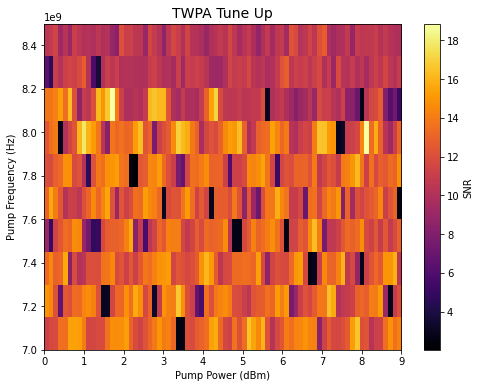

In [27]:
plt.rcParams['savefig.facecolor']='white'


get_SNR_space_plot(signal,repeated, freq_range, power_range, std_SNR=2.5, title="TWPA Tune Up", xlabel='Pump Power (dBm)', ylabel='Pump Frequency (Hz)', zlabel='SNR', fig_type=".png", path="figures")

In [38]:
get_high_SNR_regions(signal,repeated, freq_range, power_range, std_SNR=2.5, std_highSNR=1.75)

High SNR Regions:
(power,frequency,SNR)

[(0.0, 7860000000.0, 16.549866637199727), (0.0, 8320000000.0, 16.608943619218152), (1.0, 7560000000.0, 16.641488971014375), (6.0, 7160000000.0, 17.754057714765636), (6.0, 7560000000.0, 16.967961710624067), (6.0, 8360000000.0, 18.825572252895668), (7.0, 7260000000.0, 16.661992804837475), (7.0, 7280000000.0, 18.86492166172537), (7.0, 7720000000.0, 17.103504653621265)]


[(0.0, 7860000000.0, 16.549866637199727),
 (0.0, 8320000000.0, 16.608943619218152),
 (1.0, 7560000000.0, 16.641488971014375),
 (6.0, 7160000000.0, 17.754057714765636),
 (6.0, 7560000000.0, 16.967961710624067),
 (6.0, 8360000000.0, 18.825572252895668),
 (7.0, 7260000000.0, 16.661992804837475),
 (7.0, 7280000000.0, 18.86492166172537),
 (7.0, 7720000000.0, 17.103504653621265)]